# VAR, VARMA and VARMAX 

In [1]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

Source: Statistics Canada. Table 32-10-0077-01  [Farm product prices, crops and livestock](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3210007701)

In [3]:
# Load data
df = pd.read_csv('data/barley_cow_calves_price.csv')
print(df.shape)
df.head()

(370, 4)


,Date,barley,cows,calves
0,Jan-92,66.98,47.79,96.25
1,Feb-92,69.53,51.65,90.11
2,Mar-92,68.97,53.49,101.50
3,Apr-92,69.42,54.24,99.91
4,May-92,71.41,55.18,111.25


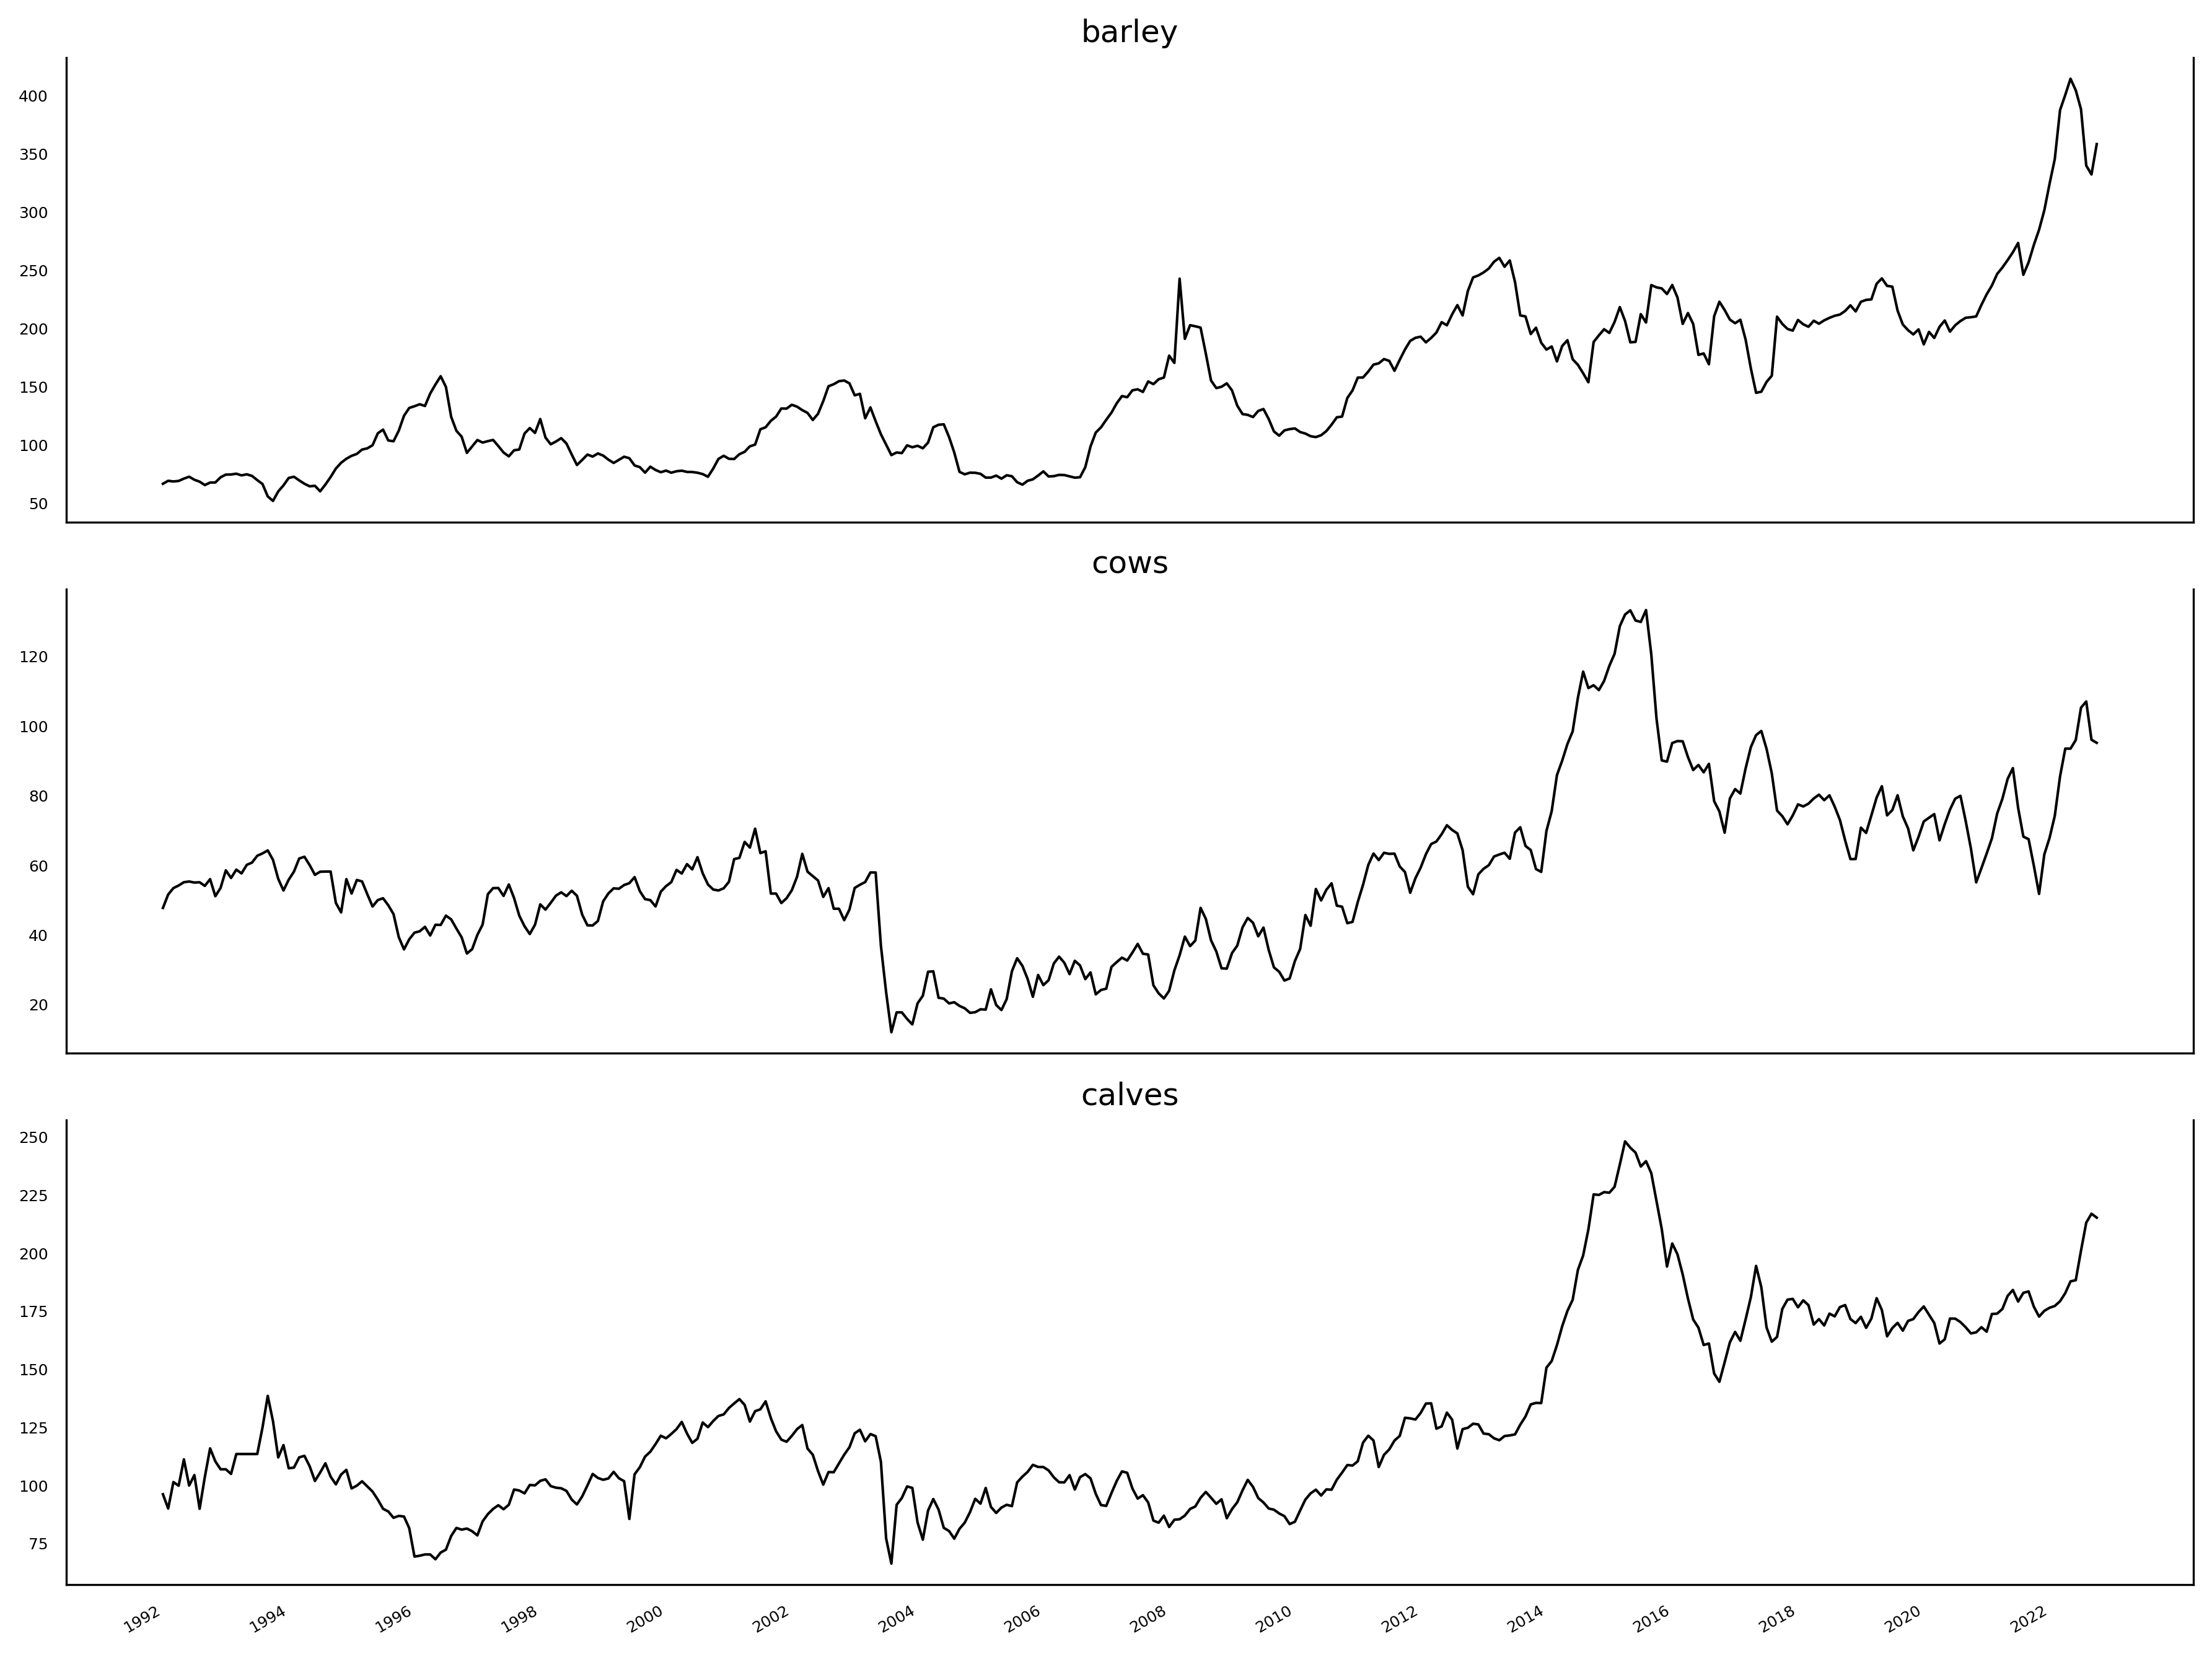

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=300, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i+1]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(df.columns[i+1])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 369, 24), xticklabels=np.arange(1992, 2023, 2))

fig.autofmt_xdate()

plt.tight_layout()

## VAR(p) 

### Check for stationarity 

In [5]:
# Run the ADF test for the "cows" series
ad_fuller_result_1 = adfuller(df['cows'])

print('cows')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

# Run the ADF test for the "calves" series
ad_fuller_result_2 = adfuller(df['calves'])
print('calves')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

cows
ADF Statistic: -1.824673327122966
p-value: 0.3682826880725809

---------------------

calves
ADF Statistic: -0.6797085372042206
p-value: 0.8519357094122593


In [6]:
# Run the ADF test for the differenced "cows" series
ad_fuller_result_1 = adfuller(df['cows'].diff()[1:])
print('cows')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

# Run the ADF test for the differences "calves" series
ad_fuller_result_2 = adfuller(df['calves'].diff()[1:])
print('calves')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

cows
ADF Statistic: -3.9172400148092836
p-value: 0.001911570559956177

---------------------

calves
ADF Statistic: -5.358388855111442
p-value: 4.139911181465891e-06


### Model selection 

In [11]:
def VAR_gridsearch(endog, min_p, max_p):
    
    # Determine the range of possible values for p
    all_p = range(min_p, max_p + 1)
    
    # Initialize an empty list to store the order and AIC
    results = []
    
    print(f'Fitting {len(all_p)} unique models')
    
    for p in tqdm_notebook(all_p):
        try:
            # Fit a VAR(p) model
            model = VARMAX(endog, order=(p, 0)).fit(disp=False)
        except:
            continue
        
        # Append the order and AIC to the list
        results.append([p, model.aic])

    # Store the results in a DataFrame and rename the columns
    result_df = pd.DataFrame(results, columns = ['p', 'AIC'])
        
    # Sort the DataFrame in ascending order of AIC
    result_df = result_df.sort_values('AIC').reset_index(drop=True)
    
    return result_df

In [12]:
# Get the endogenous variables
endog = df[['cows', 'calves']]

# Get the differenced endogenous variables
endog_diff = df[['cows', 'calves']].diff()[1:]

# Train/test split (last 48 times steps are for the test set)
train = endog_diff[:-48]
test = endog_diff[-48:]

# Run the grid search
result_df = VAR_gridsearch(train, 0, 6)
result_df

Fitting 7 unique models


  0%|          | 0/7 [00:00<?, ?it/s]

,p,AIC
0,6,3857.399348
1,5,3864.637583
2,4,3865.935543
3,3,3872.751317
4,1,3882.225272
5,2,3884.240038


In [13]:
print('calves Granger-causes cows?\n')
print('------------------')
# Run the Granger causality test calves -> cows
granger_1 = grangercausalitytests(df[['cows', 'calves']], [6])

print('\ncows Granger-causes calves?\n')
print('------------------')
# Run the Granger causality test cows -> calves
granger_2 = grangercausalitytests(df[['calves', 'cows']], [6])


calves Granger-causes cows?

------------------

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.8994  , p=0.0009  , df_denom=351, df_num=6
ssr based chi2 test:   chi2=24.2630 , p=0.0005  , df=6
likelihood ratio test: chi2=23.4886 , p=0.0006  , df=6
parameter F test:         F=3.8994  , p=0.0009  , df_denom=351, df_num=6

cows Granger-causes calves?

------------------

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.3075  , p=0.0337  , df_denom=351, df_num=6
ssr based chi2 test:   chi2=14.3577 , p=0.0259  , df=6
likelihood ratio test: chi2=14.0818 , p=0.0287  , df=6
parameter F test:         F=2.3075  , p=0.0337  , df_denom=351, df_num=6


In [14]:
VAR_model = VARMAX(train, order=(6,0))
VAR_model_fit = VAR_model.fit(disp=False)

VAR_model_fit.summary()

Dep. Variable:,"['cows', 'calves']",No. Observations:,321
Model:,VAR(6),Log Likelihood,-1899.700
,+ intercept,AIC,3857.399
Date:,"Sun, 24 Mar 2024",BIC,3966.771
Time:,10:06:11,HQIC,3901.069
Sample:,0,,
,- 321,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.16, 0.05",Jarque-Bera (JB):,"116.37, 48.74"
Prob(Q):,"0.69, 0.81",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"2.22, 0.93",Skew:,"-0.49, -0.18"


### Residuals analysis
#### cows

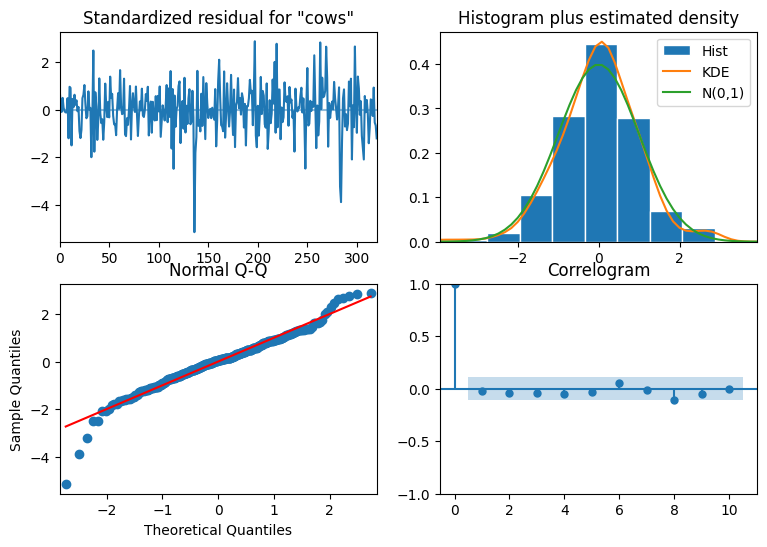

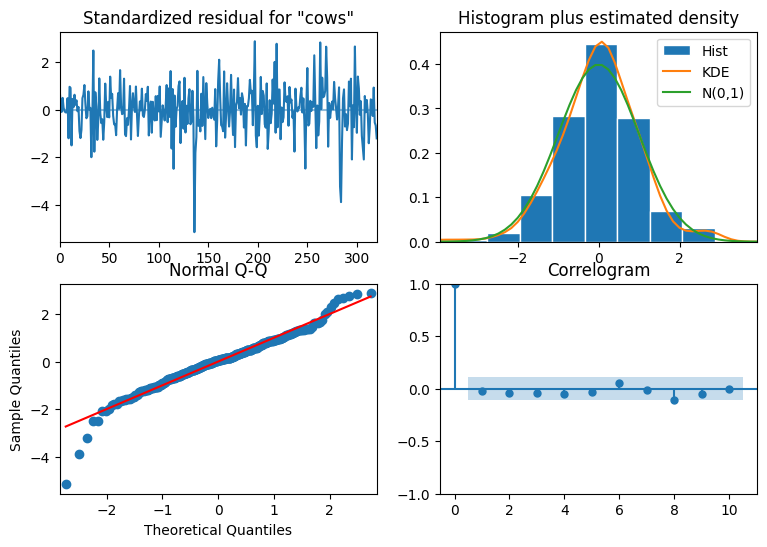

In [15]:
# cows
VAR_model_fit.plot_diagnostics(variable=0)

In [16]:
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('At least one p-value is smaller than 0.05')

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


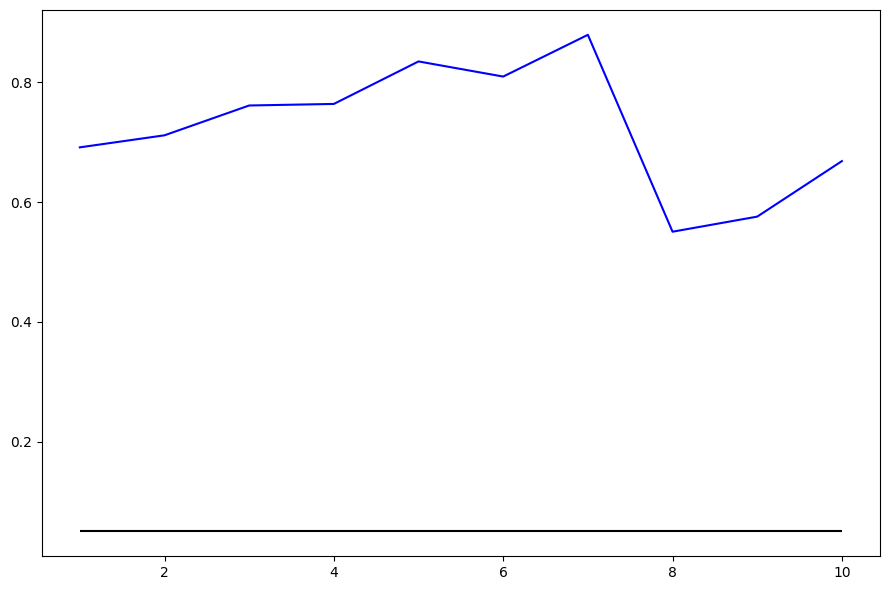

In [17]:
# define residuals
residuals = VAR_model_fit.resid['cows']

ljung_box_test(residuals, False, None)

#### calves 

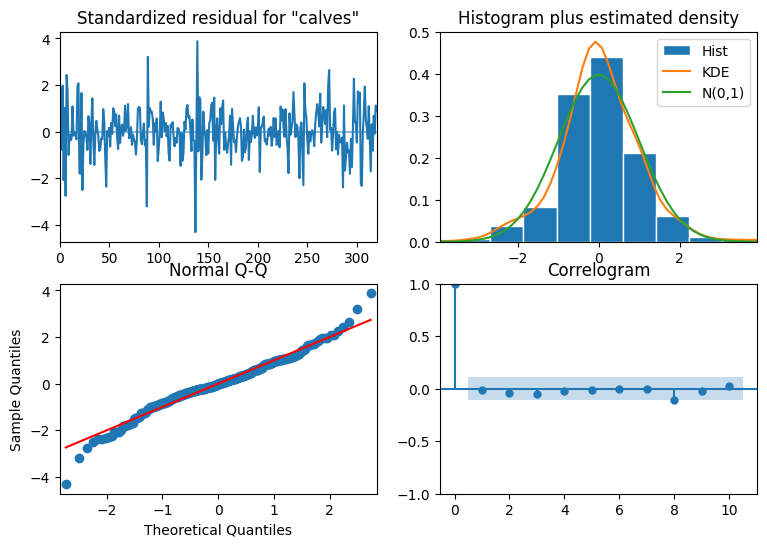

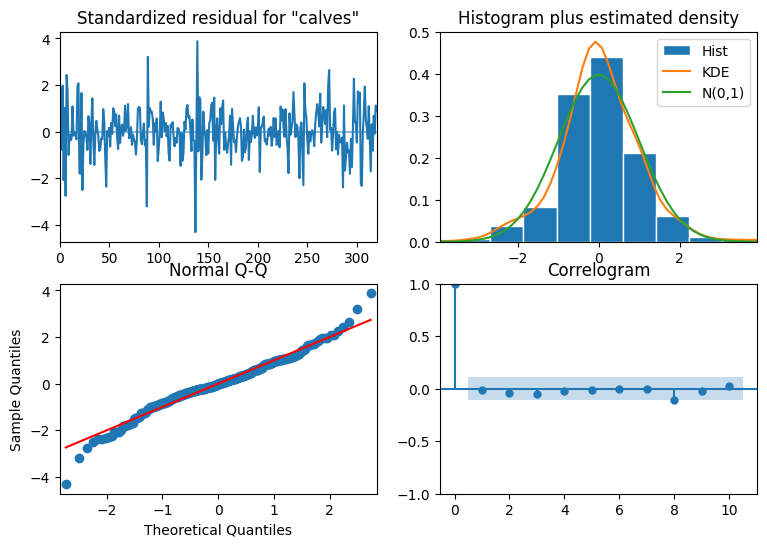

In [18]:
# calves
VAR_model_fit.plot_diagnostics(variable=1)

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


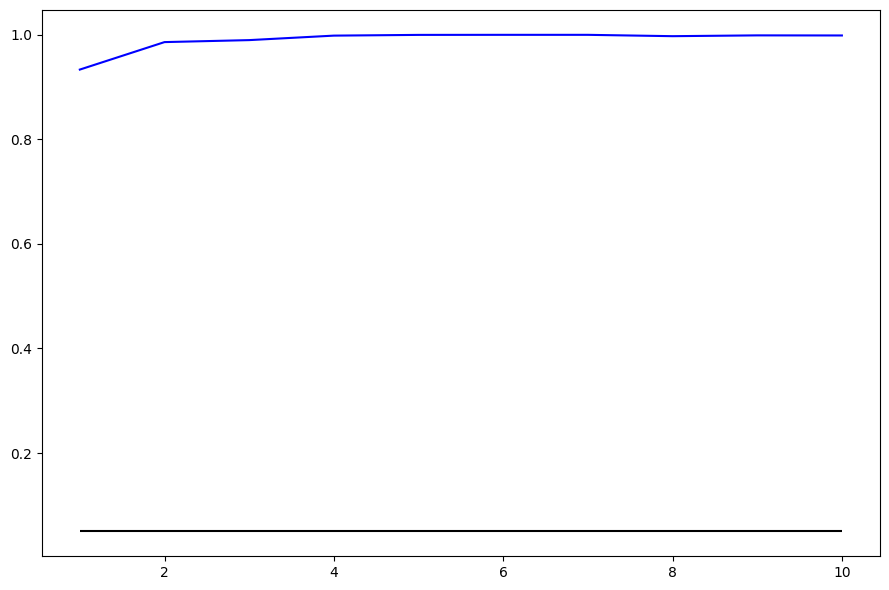

In [19]:
# define residuals
residuals = VAR_model_fit.resid['calves']

ljung_box_test(residuals, False, None)

### Forecasting

In [22]:
def rolling_predictions(df, last_train_value, train_len, horizon, window, method):
    
    total_len = train_len + horizon
    
    if method == 'VAR':

        # Get the predictions from the VAR model
        cows_pred_VAR = []
        calves_pred_VAR = []

        # iterate through
        for i in range(train_len, total_len, window):

            model = VARMAX(df[:i], order=(6,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)

            oos_pred_cows = predictions.predicted_mean.iloc[-window:]['cows']
            oos_pred_calves = predictions.predicted_mean.iloc[-window:]['calves']

            cows_pred_VAR.extend(oos_pred_cows)
            calves_pred_VAR.extend(oos_pred_calves)

        cows_pred_VAR = np.insert(cows_pred_VAR, 0, last_train_value['cows'])
        cows_pred_VAR = cows_pred_VAR.cumsum()

        calves_pred_VAR = np.insert(calves_pred_VAR, 0, last_train_value['calves'])
        calves_pred_VAR = calves_pred_VAR.cumsum()
        
        return cows_pred_VAR[:horizon], calves_pred_VAR[:horizon]
    
    elif method == 'last':
        cows_pred_last = []
        calves_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            cows_last = df[:i].iloc[-1]['cows']
            calves_last = df[:i].iloc[-1]['calves']
            
            cows_pred_last.extend(cows_last for _ in range(window))
            calves_pred_last.extend(calves_last for _ in range(window))
        
        cows_pred_last = np.insert(cows_pred_last, 0, last_train_value['cows'])
        cows_pred_last = cows_pred_last.cumsum()
        
        calves_pred_last = np.insert(calves_pred_last, 0, last_train_value['calves'])
        calves_pred_last = calves_pred_last.cumsum()
            
        return cows_pred_last[:horizon], calves_pred_last[:horizon]

In [23]:
pred_df = df[['cows', 'calves']][-48:]

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = endog.iloc[321]

windows = [1, 4, 6, 12]

for window in windows:
    cows_pred_last, calves_pred_last = rolling_predictions(endog_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'last')
    cows_pred_VAR, calves_pred_VAR = rolling_predictions(endog_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'VAR')
    
    pred_df[f'cows_pred_last_{window}'] = cows_pred_last
    pred_df[f'calves_pred_last_{window}'] = calves_pred_last
    pred_df[f'cows_pred_VAR_{window}'] = cows_pred_VAR
    pred_df[f'calves_pred_VAR_{window}'] = calves_pred_VAR
    
pred_df.head()

,cows,calves,cows_pred_last_1,calves_pred_last_1,cows_pred_VAR_1,calves_pred_VAR_1,cows_pred_last_4,calves_pred_last_4,cows_pred_VAR_4,calves_pred_VAR_4,cows_pred_last_6,calves_pred_last_6,cows_pred_VAR_6,calves_pred_VAR_6,cows_pred_last_12,calves_pred_last_12,cows_pred_VAR_12,calves_pred_VAR_12
322,61.81,171.68,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000
323,61.85,169.94,61.30,178.56,66.948169,176.391738,61.30,178.56,66.948169,176.391738,61.30,178.56,66.948169,176.391738,61.30,178.56,66.948169,176.391738
324,70.84,172.67,55.94,172.54,67.358382,174.392420,55.43,179.42,68.581829,176.128407,55.43,179.42,68.581829,176.128407,55.43,179.42,68.581829,176.128407
325,69.34,167.90,55.98,170.80,69.223348,175.614713,49.56,180.28,71.353641,178.178357,49.56,180.28,71.353641,178.178357,49.56,180.28,71.353641,178.178357
326,74.36,171.88,64.97,173.53,73.689360,179.524382,43.69,181.14,74.045799,179.656663,43.69,181.14,74.045799,179.656663,43.69,181.14,74.045799,179.656663


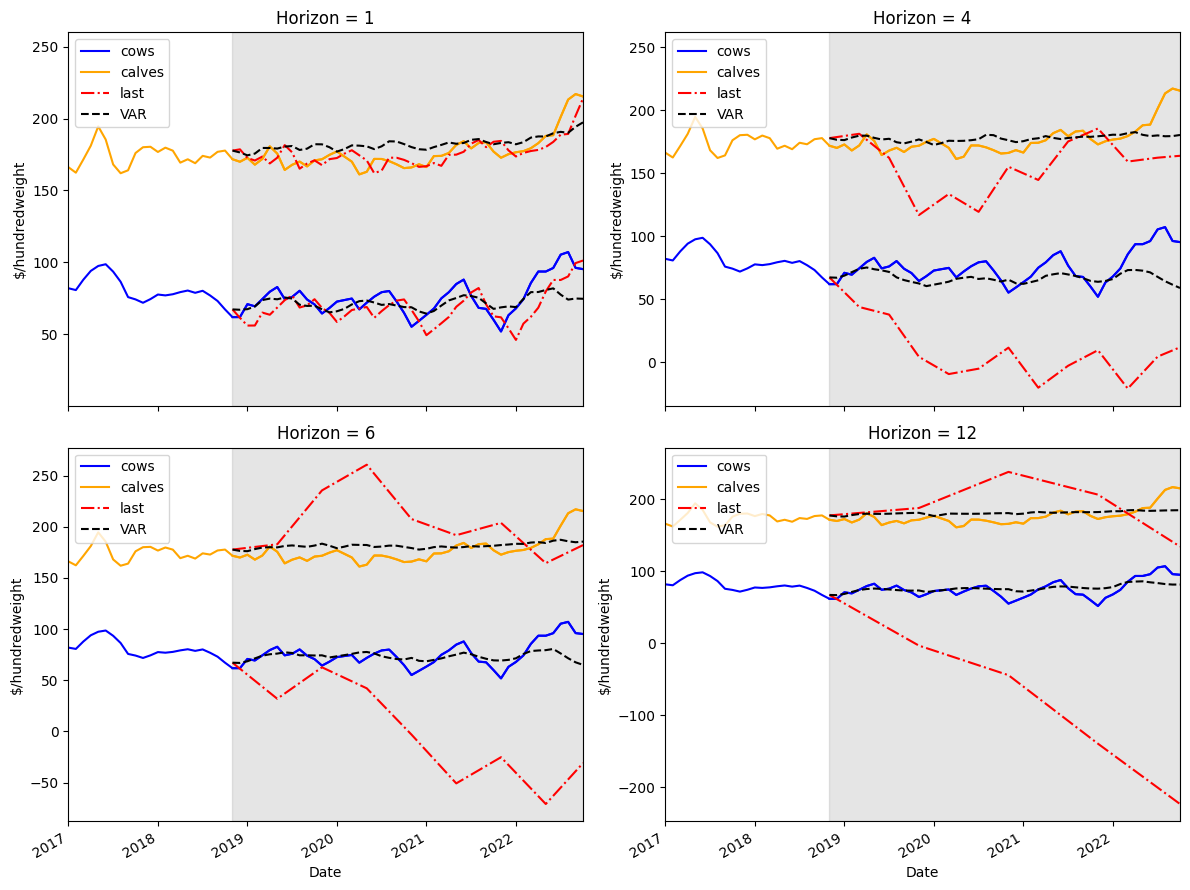

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['cows'], color='blue')
    ax.plot(df['calves'], color='orange')
    ax.plot(pred_df['cows'], color='blue', label='cows')
    ax.plot(pred_df['calves'], color='orange', label='calves')
    ax.plot(pred_df[f'cows_pred_last_{windows[i]}'], 'r-.', label='last')
    ax.plot(pred_df[f'calves_pred_last_{windows[i]}'], 'r-.')
    ax.plot(pred_df[f'cows_pred_VAR_{windows[i]}'], 'k--', label='VAR')
    ax.plot(pred_df[f'calves_pred_VAR_{windows[i]}'], 'k--')
    ax.legend(loc=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('$/hundredweight')
    ax.axvspan(322, 369, color='#808080', alpha=0.2)
    ax.set_xlim(300, 369)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.setp(axes, xticks=np.arange(300, 369, 12), xticklabels=np.arange(2017, 2023, 1))

fig.autofmt_xdate()
plt.tight_layout()

### Evaluation 

In [25]:
from sklearn.metrics import mean_absolute_error

mae_cow_last_1 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_1'])
mae_calves_last_1 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_1'])
mae_cow_VAR_1 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VAR_1'])
mae_calves_VAR_1 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VAR_1'])

mae_cow_last_4 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_4'])
mae_calves_last_4 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_4'])
mae_cow_VAR_4 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VAR_4'])
mae_calves_VAR_4 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VAR_4'])

mae_cow_last_6 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_6'])
mae_calves_last_6 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_6'])
mae_cow_VAR_6 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VAR_6'])
mae_calves_VAR_6 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VAR_6'])

mae_cow_last_12 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_12'])
mae_calves_last_12 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_12'])
mae_cow_VAR_12 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VAR_12'])
mae_calves_VAR_12 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VAR_12'])

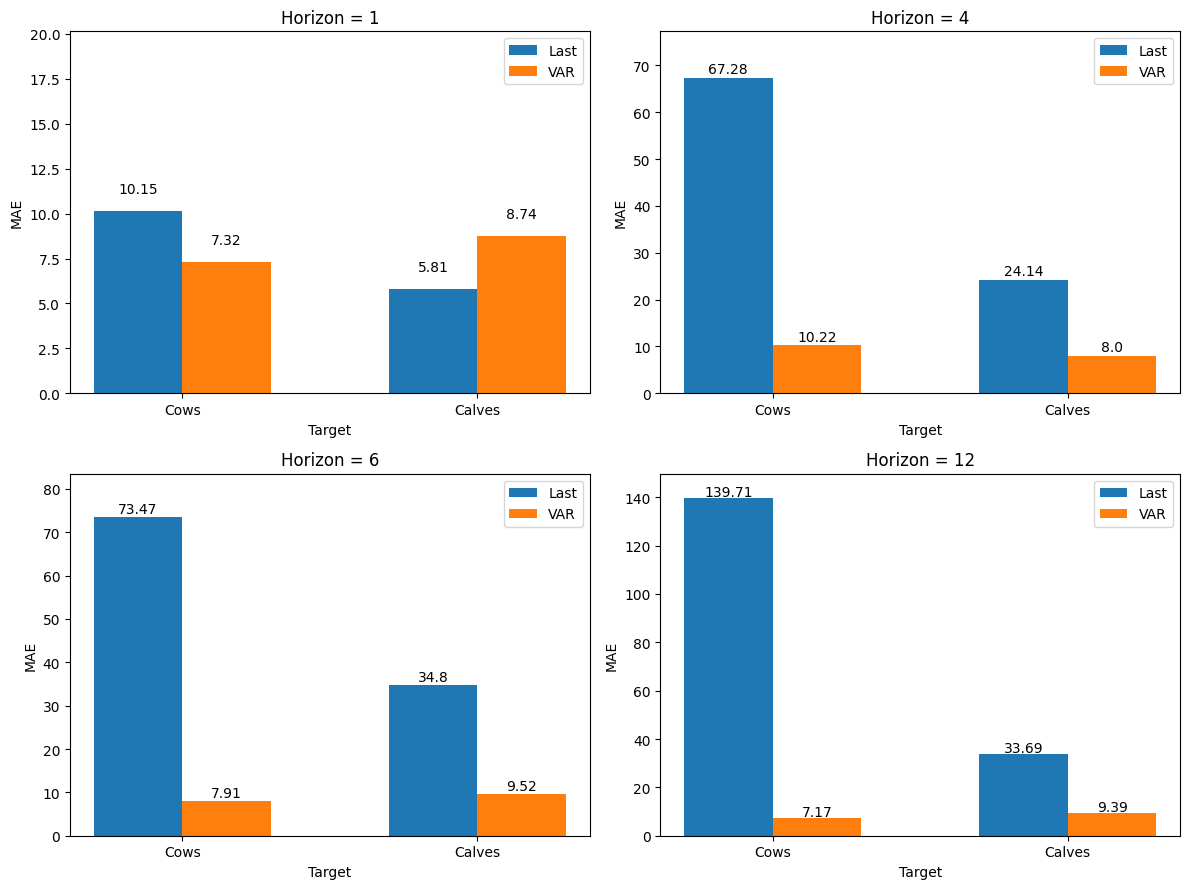

In [26]:
mae_cows_last = [mae_cow_last_1, mae_cow_last_4, mae_cow_last_6, mae_cow_last_12]
mae_calves_last = [mae_calves_last_1, mae_calves_last_4, mae_calves_last_6, mae_calves_last_12]
mae_cows_VAR = [mae_cow_VAR_1, mae_cow_VAR_4, mae_cow_VAR_6, mae_cow_VAR_12]
mae_calves_VAR = [mae_calves_VAR_1, mae_calves_VAR_4, mae_calves_VAR_6, mae_calves_VAR_12]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

width = 0.3
labels = ['Cows', 'Calves']
x = np.arange(len(labels))

for i, ax in enumerate(axes.flatten()):
    y_last = [mae_cows_last[i], mae_calves_last[i]]
    y_VAR = [mae_cows_VAR[i], mae_calves_VAR[i]]
    
    ax.bar(x - width/2, y_last, width, label='Last')
    ax.bar(x + width/2, y_VAR, width, label='VAR')
    
    ax.set_ylim(0, max(y_last) + 10)
    ax.set_ylabel('MAE')
    ax.set_xlabel('Target')
    ax.set_title(f'Horizon = {windows[i]}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='best')
    
    for i, v in enumerate(y_last):
        ax.text(x=i - width/2, y=v+1, s=str(round(v, 2)), ha='center')
    for i, v in enumerate(y_VAR):
        ax.text(x=i + width/2, y=v+1, s=str(round(v, 2)), ha='center')
    
plt.tight_layout()

## VARMA(p,q) 

In [27]:
def VARMA_gridsearch(endog, min_p, max_p, min_q, max_q):
    
    all_p = range(min_p, max_p+1, 1)
    # Define the range of values for q
    all_q = range(min_q, max_q + 1)

    # Make a list of all possible (p,q) combinations
    all_orders = list(product(all_p, all_q))
    
    results = []
    
    print(f'Fitting {len(all_orders)} unique models')
    
    for order in tqdm_notebook(all_orders):
        try:
            # Fit a VARMA model
            model = VARMAX(endog, order=order).fit(disp=False)
        except:
            continue
    
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [28]:
result_VARMA = VARMA_gridsearch(train, 0,6,0,6)
result_VARMA

Fitting 49 unique models


  0%|          | 0/49 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(6, 4)",3773.391826
1,"(6, 1)",3775.388391
2,"(5, 4)",3778.606970
3,"(6, 2)",3778.983041
4,"(4, 5)",3779.080229
5,"(5, 5)",3785.865636
6,"(6, 5)",3788.642700
7,"(5, 6)",3789.078467
8,"(4, 1)",3789.145589
9,"(5, 3)",3790.811075


We don't need to redo the Granger causality test, since $p=6$

In [29]:
VARMA_model = VARMAX(train, order=(6,4))
VARMA_model_fit = VARMA_model.fit(disp=False)

VARMA_model_fit.summary()

Dep. Variable:,"['cows', 'calves']",No. Observations:,321
Model:,"VARMA(6,4)",Log Likelihood,-1841.696
,+ intercept,AIC,3773.392
Date:,"Sun, 24 Mar 2024",BIC,3943.107
Time:,11:11:33,HQIC,3841.155
Sample:,0,,
,- 321,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.76, 0.82",Jarque-Bera (JB):,"247.25, 48.80"
Prob(Q):,"0.38, 0.37",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"2.47, 0.91",Skew:,"-0.69, -0.02"


### Residuals analysis 

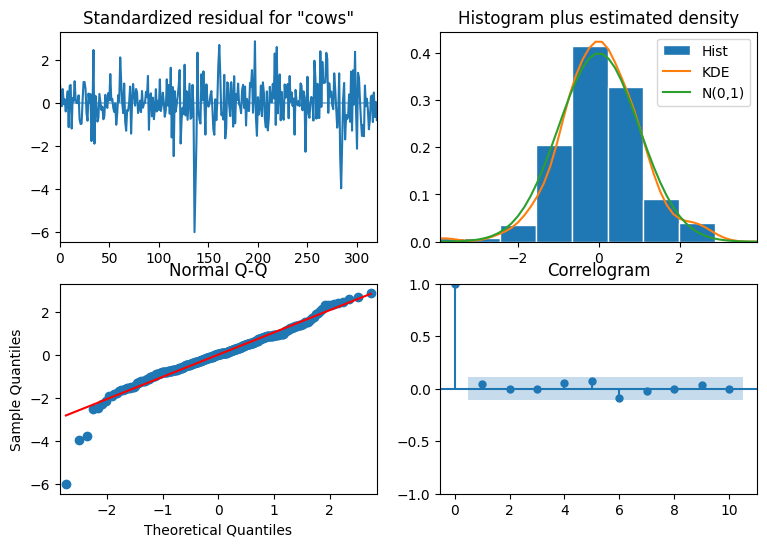

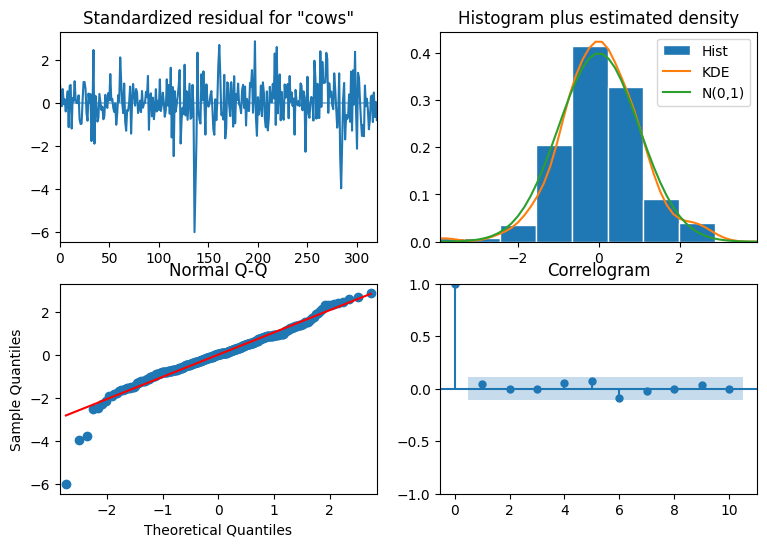

In [30]:
# cows
VARMA_model_fit.plot_diagnostics(variable=0)


All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


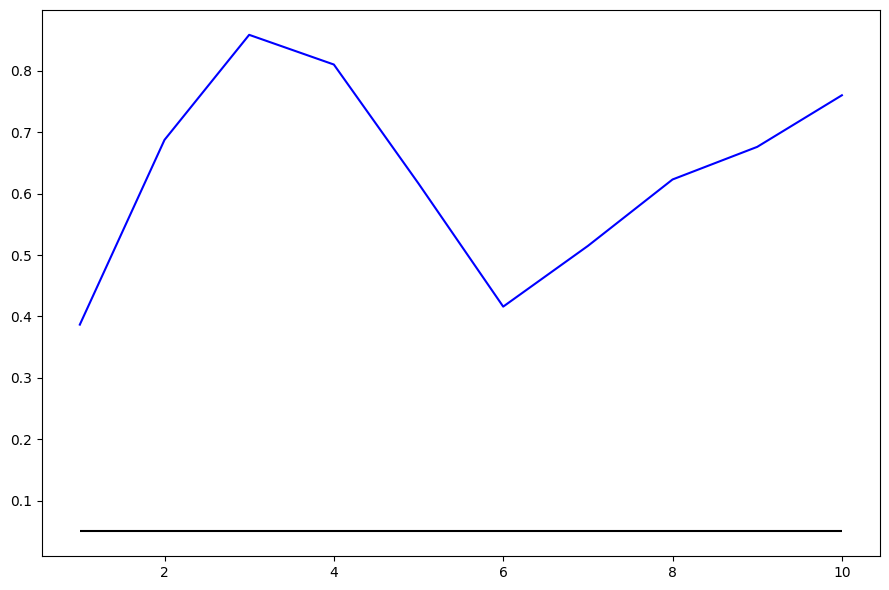

In [31]:
residuals = VARMA_model_fit.resid['cows']

ljung_box_test(residuals, False, None)

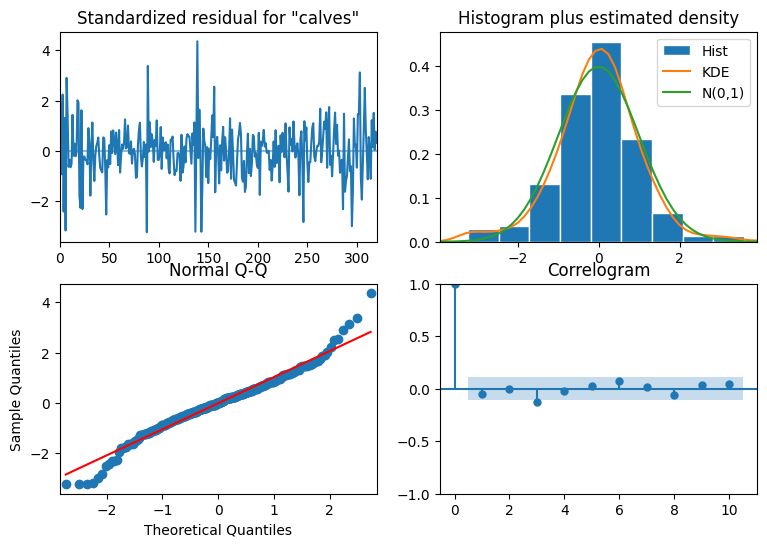

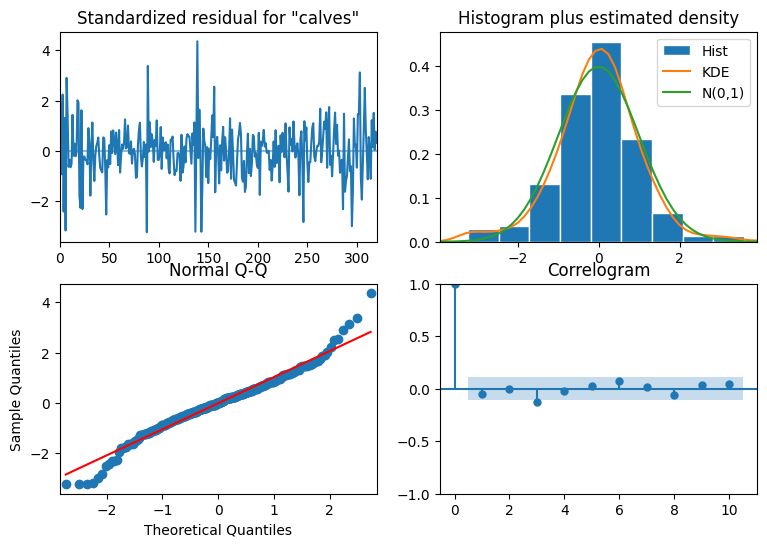

In [32]:
# calves
VARMA_model_fit.plot_diagnostics(variable=1)

At least one p-value is smaller than 0.05


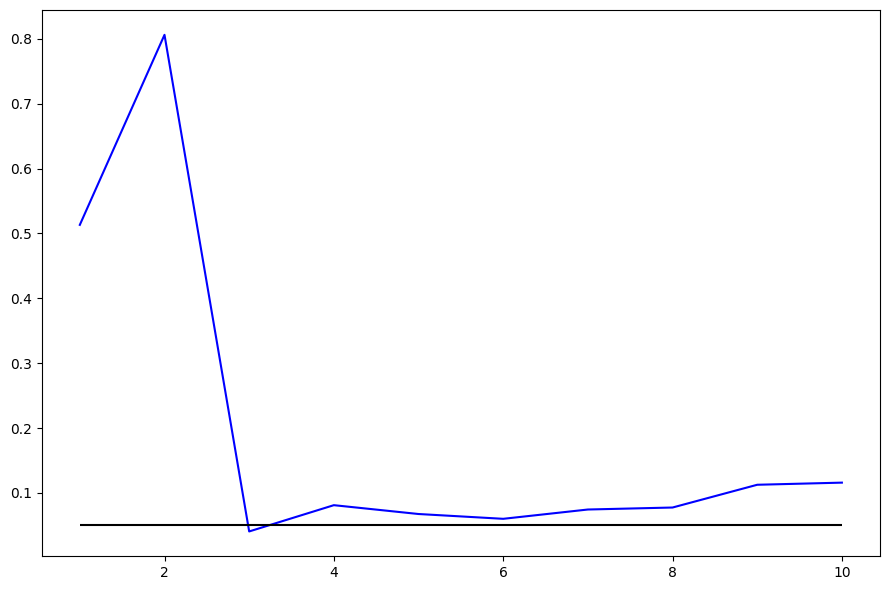

In [34]:
residuals = VARMA_model_fit.resid['calves']

ljung_box_test(residuals, False, None)

### Forecasting 

In [35]:
def rolling_predictions(df, last_train_value, train_len, horizon, window, method):
    
    total_len = train_len + horizon
    
    if method == 'VARMA':

        cows_pred_VARMA = []
        calves_pred_VARMA = []
        
        for i in range(train_len, total_len, window):
            # Initialize the VARMA(p,q) model

            model = VARMAX(df[:i], order=(6,4))
            
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_cows = predictions.predicted_mean.iloc[-window:]['cows']
            oos_pred_calves = predictions.predicted_mean.iloc[-window:]['calves']
            
            cows_pred_VARMA.extend(oos_pred_cows)
            calves_pred_VARMA.extend(oos_pred_calves)
            
        cows_pred_VARMA = np.insert(cows_pred_VARMA, 0, last_train_value['cows'])
        cows_pred_VARMA = cows_pred_VARMA.cumsum()
        
        calves_pred_VARMA = np.insert(calves_pred_VARMA, 0, last_train_value['calves'])
        calves_pred_VARMA = calves_pred_VARMA.cumsum()
        
        return cows_pred_VARMA[:horizon], calves_pred_VARMA[:horizon]
    
    elif method == 'last':
        cows_pred_last = []
        calves_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            cows_last = df[:i].iloc[-1]['cows']
            calves_last = df[:i].iloc[-1]['calves']
            
            cows_pred_last.extend(cows_last for _ in range(window))
            calves_pred_last.extend(calves_last for _ in range(window))
        
        cows_pred_last = np.insert(cows_pred_last, 0, last_train_value['cows'])
        cows_pred_last = cows_pred_last.cumsum()
        
        calves_pred_last = np.insert(calves_pred_last, 0, last_train_value['calves'])
        calves_pred_last = calves_pred_last.cumsum()
            
        return cows_pred_last[:horizon], calves_pred_last[:horizon]

In [36]:
pred_df = df[['cows', 'calves']][-48:]

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = endog.iloc[321]

windows = [1, 4, 6, 12]

for window in windows:
    cows_pred_last, calves_pred_last = rolling_predictions(endog_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'last')
    cows_pred_VARMA, calves_pred_VARMA = rolling_predictions(endog_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'VARMA')
    
    pred_df[f'cows_pred_last_{window}'] = cows_pred_last
    pred_df[f'calves_pred_last_{window}'] = calves_pred_last
    pred_df[f'cows_pred_VARMA_{window}'] = cows_pred_VARMA
    pred_df[f'calves_pred_VARMA_{window}'] = calves_pred_VARMA
    
pred_df.head()

,cows,calves,cows_pred_last_1,calves_pred_last_1,cows_pred_VARMA_1,calves_pred_VARMA_1,cows_pred_last_4,calves_pred_last_4,cows_pred_VARMA_4,calves_pred_VARMA_4,cows_pred_last_6,calves_pred_last_6,cows_pred_VARMA_6,calves_pred_VARMA_6,cows_pred_last_12,calves_pred_last_12,cows_pred_VARMA_12,calves_pred_VARMA_12
322,61.81,171.68,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000
323,61.85,169.94,61.30,178.56,65.497036,177.935709,61.30,178.56,65.497036,177.935709,61.30,178.56,65.497036,177.935709,61.30,178.56,65.497036,177.935709
324,70.84,172.67,55.94,172.54,65.374826,177.519913,55.43,179.42,65.842612,179.208849,55.43,179.42,65.842612,179.208849,55.43,179.42,65.842612,179.208849
325,69.34,167.90,55.98,170.80,67.524464,180.423694,49.56,180.28,68.890965,182.266471,49.56,180.28,68.890965,182.266471,49.56,180.28,68.890965,182.266471
326,74.36,171.88,64.97,173.53,69.727618,185.603676,43.69,181.14,71.917157,184.655306,43.69,181.14,71.917157,184.655306,43.69,181.14,71.917157,184.655306


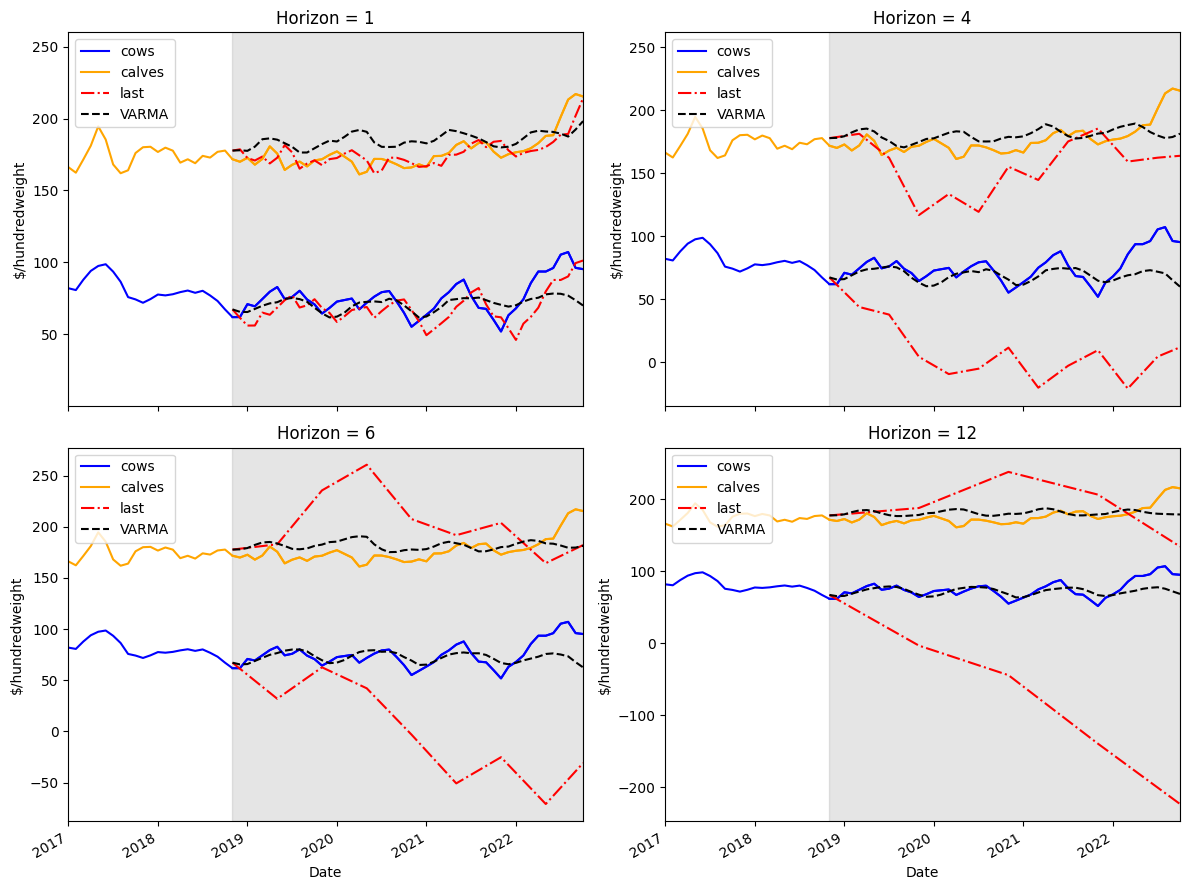

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['cows'], color='blue')
    ax.plot(df['calves'], color='orange')
    ax.plot(pred_df['cows'], color='blue', label='cows')
    ax.plot(pred_df['calves'], color='orange', label='calves')
    ax.plot(pred_df[f'cows_pred_last_{windows[i]}'], 'r-.', label='last')
    ax.plot(pred_df[f'calves_pred_last_{windows[i]}'], 'r-.')
    ax.plot(pred_df[f'cows_pred_VARMA_{windows[i]}'], 'k--', label='VARMA')
    ax.plot(pred_df[f'calves_pred_VARMA_{windows[i]}'], 'k--')
    ax.legend(loc=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('$/hundredweight')
    ax.axvspan(322, 369, color='#808080', alpha=0.2)
    ax.set_xlim(300, 369)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.setp(axes, xticks=np.arange(300, 369, 12), xticklabels=np.arange(2017, 2023, 1))

fig.autofmt_xdate()
plt.tight_layout()

### Evaluation 

In [38]:
mae_cow_last_1 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_1'])
mae_calves_last_1 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_1'])
mae_cow_VARMA_1 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VARMA_1'])
mae_calves_VARMA_1 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VARMA_1'])

mae_cow_last_4 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_4'])
mae_calves_last_4 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_4'])
mae_cow_VARMA_4 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VARMA_4'])
mae_calves_VARMA_4 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VARMA_4'])

mae_cow_last_6 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_6'])
mae_calves_last_6 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_6'])
mae_cow_VARMA_6 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VARMA_6'])
mae_calves_VARMA_6 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VARMA_6'])

mae_cow_last_12 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_12'])
mae_calves_last_12 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_12'])
mae_cow_VARMA_12 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VARMA_12'])
mae_calves_VARMA_12 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VARMA_12'])

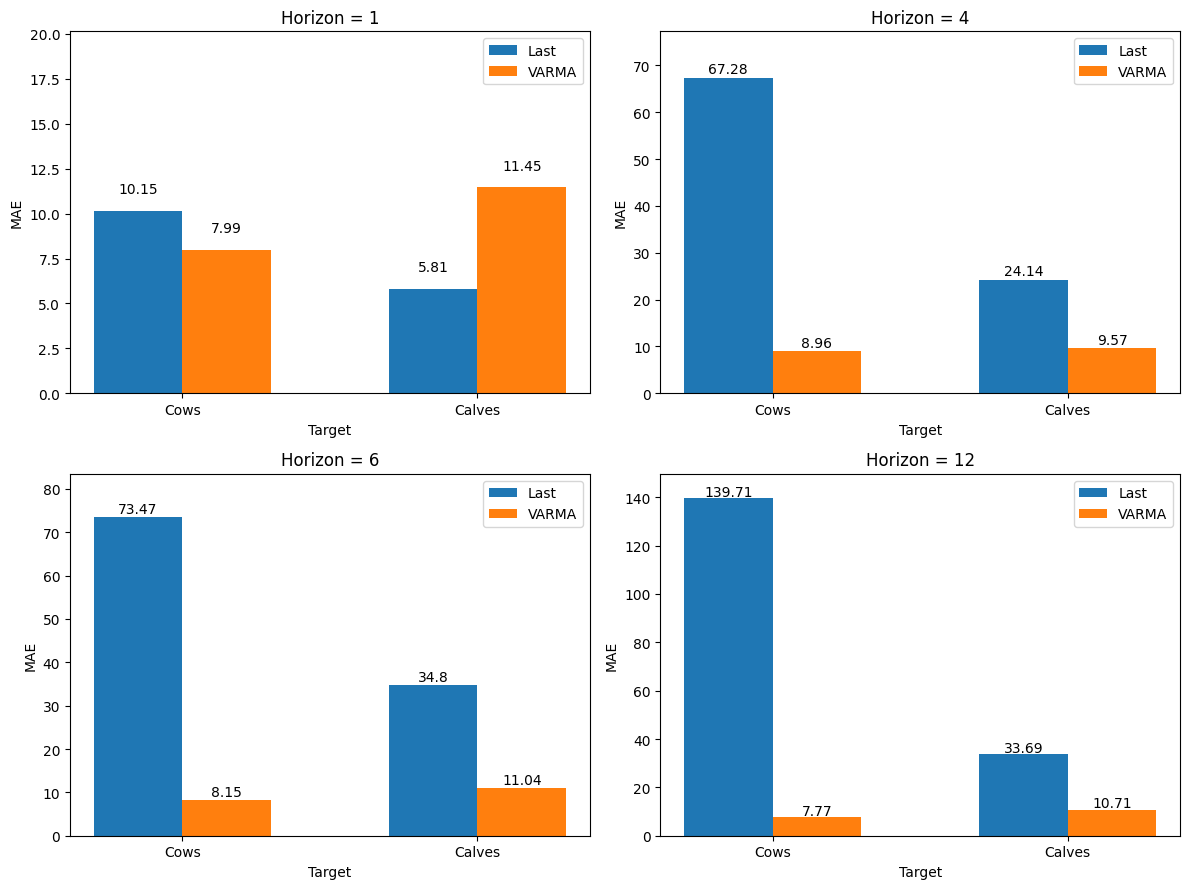

In [39]:
mae_cows_last = [mae_cow_last_1, mae_cow_last_4, mae_cow_last_6, mae_cow_last_12]
mae_calves_last = [mae_calves_last_1, mae_calves_last_4, mae_calves_last_6, mae_calves_last_12]
mae_cows_VARMA = [mae_cow_VARMA_1, mae_cow_VARMA_4, mae_cow_VARMA_6, mae_cow_VARMA_12]
mae_calves_VARMA = [mae_calves_VARMA_1, mae_calves_VARMA_4, mae_calves_VARMA_6, mae_calves_VARMA_12]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

width = 0.3
labels = ['Cows', 'Calves']
x = np.arange(len(labels))

for i, ax in enumerate(axes.flatten()):
    y_last = [mae_cows_last[i], mae_calves_last[i]]
    y_VARMA = [mae_cows_VARMA[i], mae_calves_VARMA[i]]
    
    ax.bar(x - width/2, y_last, width, label='Last')
    ax.bar(x + width/2, y_VARMA, width, label='VARMA')
    
    ax.set_ylim(0, max(y_last) + 10)
    ax.set_ylabel('MAE')
    ax.set_xlabel('Target')
    ax.set_title(f'Horizon = {windows[i]}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='best')
    
    for i, v in enumerate(y_last):
        ax.text(x=i - width/2, y=v+1, s=str(round(v, 2)), ha='center')
    for i, v in enumerate(y_VARMA):
        ax.text(x=i + width/2, y=v+1, s=str(round(v, 2)), ha='center')
    
plt.tight_layout()

## VARMAX 

In [40]:
def VARMAX_gridsearch(endog, exog, min_p, max_p, min_q, max_q):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_orders = list(product(all_p, all_q))
    
    print(f'Fitting {len(all_orders)} unique models')
    
    results = []
    
    for order in tqdm_notebook(all_orders):
        try:
            # Fit a VARMAX model
            model = VARMAX(endog, exog, order=order).fit(disp=False)
            
        except:
            continue
    
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [41]:
# Get your exogenous variable

# Index of exog must align with the training set
exog = df['barley'].iloc[1:322]
# Run the grid search
result_VARMAX = VARMAX_gridsearch(train, exog, 0,6, 0, 6)


Fitting 49 unique models


  0%|          | 0/49 [00:00<?, ?it/s]

In [42]:
result_VARMAX.head()

,"(p,q)",AIC
0,"(6, 4)",3839.981147
1,"(6, 1)",3841.798855
2,"(6, 5)",3845.801014
3,"(6, 2)",3847.996036
4,"(5, 2)",3851.111959


We don't need to redo the Granger causality test since $p=6$

In [43]:
VARMAX_model = VARMAX(train, exog,order=(6,4))
VARMAX_model_fit = VARMAX_model.fit(disp=False)

VARMAX_model_fit.summary()

Dep. Variable:,"['cows', 'calves']",No. Observations:,321
Model:,"VARMAX(6,4)",Log Likelihood,-1872.991
,+ intercept,AIC,3839.981
Date:,"Sun, 24 Mar 2024",BIC,4017.239
Time:,12:21:46,HQIC,3910.756
Sample:,0,,
,- 321,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 0.95",Jarque-Bera (JB):,"127.39, 42.61"
Prob(Q):,"0.95, 0.33",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"2.49, 0.93",Skew:,"-0.52, -0.15"


### Residuals analysis 

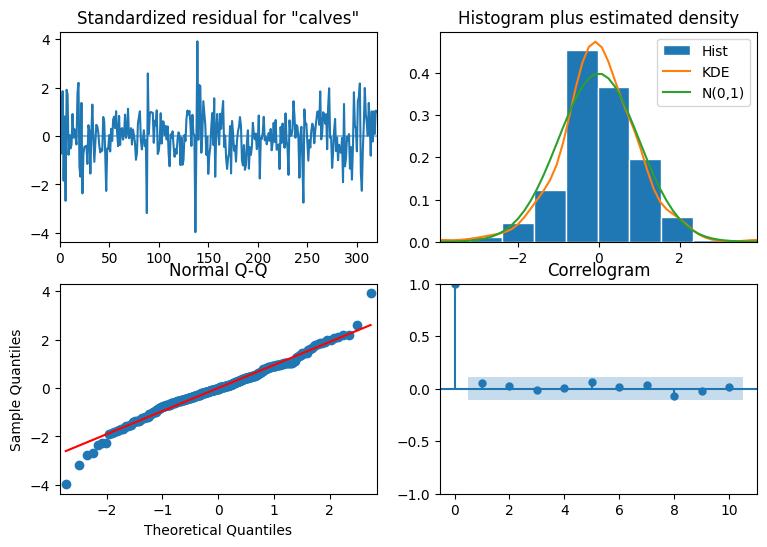

In [44]:
# cows
VARMAX_model_fit.plot_diagnostics(variable=1);

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


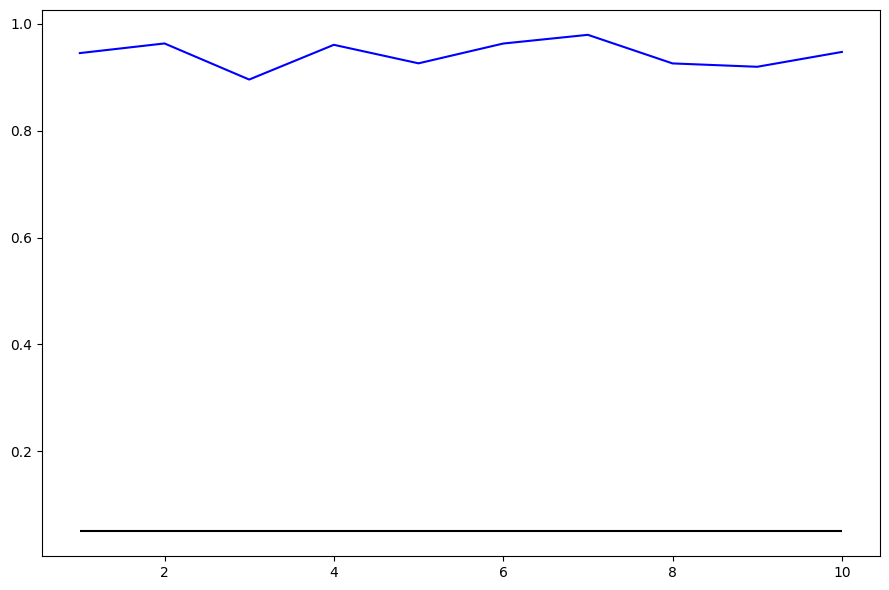

In [45]:
residuals = VARMAX_model_fit.resid['cows']

ljung_box_test(residuals, False, None)

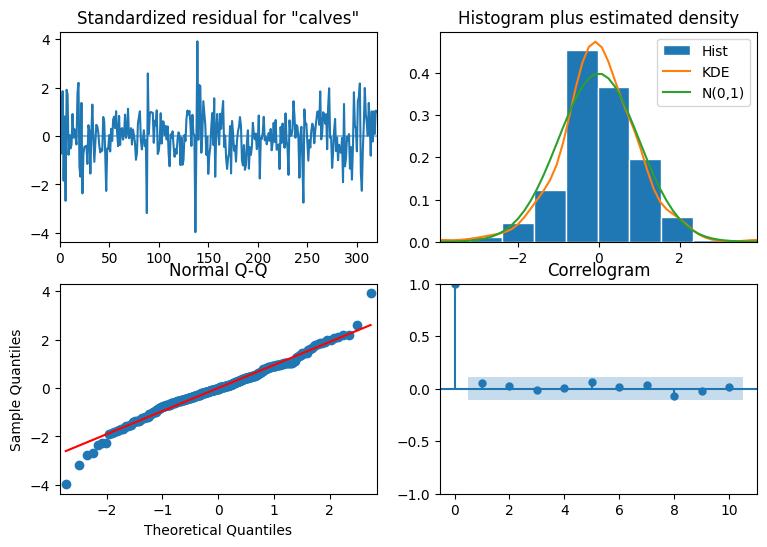

In [46]:
# calves
VARMAX_model_fit.plot_diagnostics(variable=1);

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


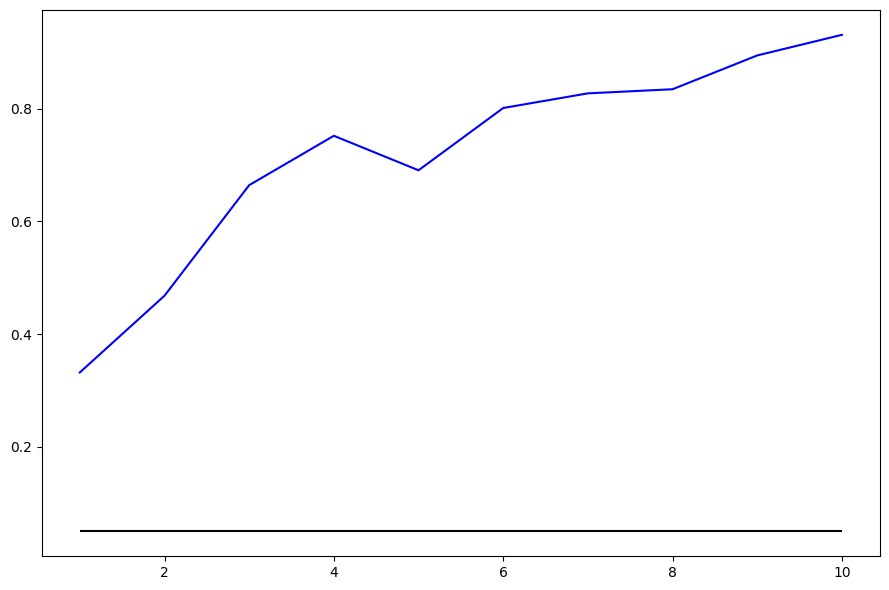

In [48]:
residuals = VARMAX_model_fit.resid['calves']

ljung_box_test(residuals, False, None)

### Forecasting 

In [49]:
def rolling_predictions(df, exog, last_train_value, train_len, horizon, window, method):
    
    total_len = train_len + horizon
    
    if method == 'VARMAX':

        cows_pred_VARMAX = []
        calves_pred_VARMAX = []
        
        for i in range(train_len, total_len, window):
            # Get he predictions from VARAMX
            model = VARMAX(df[:i], exog[:i], order=(6,4))
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog[:i])
            
            oos_pred_cows = predictions.predicted_mean.iloc[-window:]['cows']
            oos_pred_calves = predictions.predicted_mean.iloc[-window:]['calves']
            
            cows_pred_VARMAX.extend(oos_pred_cows)
            calves_pred_VARMAX.extend(oos_pred_calves)
            
        cows_pred_VARMAX = np.insert(cows_pred_VARMAX, 0, last_train_value['cows'])
        cows_pred_VARMAX = cows_pred_VARMAX.cumsum()
        
        calves_pred_VARMAX = np.insert(calves_pred_VARMAX, 0, last_train_value['calves'])
        calves_pred_VARMAX = calves_pred_VARMAX.cumsum()
        
        return cows_pred_VARMAX[:horizon], calves_pred_VARMAX[:horizon]
    
    elif method == 'last':
        cows_pred_last = []
        calves_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            cows_last = df[:i].iloc[-1]['cows']
            calves_last = df[:i].iloc[-1]['calves']
            
            cows_pred_last.extend(cows_last for _ in range(window))
            calves_pred_last.extend(calves_last for _ in range(window))
        
        cows_pred_last = np.insert(cows_pred_last, 0, last_train_value['cows'])
        cows_pred_last = cows_pred_last.cumsum()
        
        calves_pred_last = np.insert(calves_pred_last, 0, last_train_value['calves'])
        calves_pred_last = calves_pred_last.cumsum()
            
        return cows_pred_last[:horizon], calves_pred_last[:horizon]

In [50]:
pred_df = df[['cows', 'calves']][-48:]
exog = df['barley'][1:]

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = endog.iloc[321]
WINDOW = 1

cows_pred_last, calves_pred_last = rolling_predictions(endog_diff, exog, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, WINDOW, 'last')
cows_pred_VARMAX, calves_pred_VARMAX = rolling_predictions(endog_diff, exog, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')
    
pred_df[f'cows_pred_last'] = cows_pred_last
pred_df[f'calves_pred_last'] = calves_pred_last
pred_df[f'cows_pred_VARMAX'] = cows_pred_VARMAX
pred_df[f'calves_pred_VARMAX'] = calves_pred_VARMAX
    
pred_df.head()

,cows,calves,cows_pred_last,calves_pred_last,cows_pred_VARMAX,calves_pred_VARMAX
322,61.81,171.68,67.17,177.70,67.170000,177.700000
323,61.85,169.94,61.30,178.56,65.952695,175.603673
324,70.84,172.67,55.94,172.54,64.846779,173.458813
325,69.34,167.90,55.98,170.80,64.521005,170.562153
326,74.36,171.88,64.97,173.53,66.264751,170.898829


### Evaluation 

In [51]:
mae_cow_last = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last'])
mae_calves_last = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last'])
mae_cow_VARMAX = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VARMAX'])
mae_calves_VARMAX = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VARMAX'])

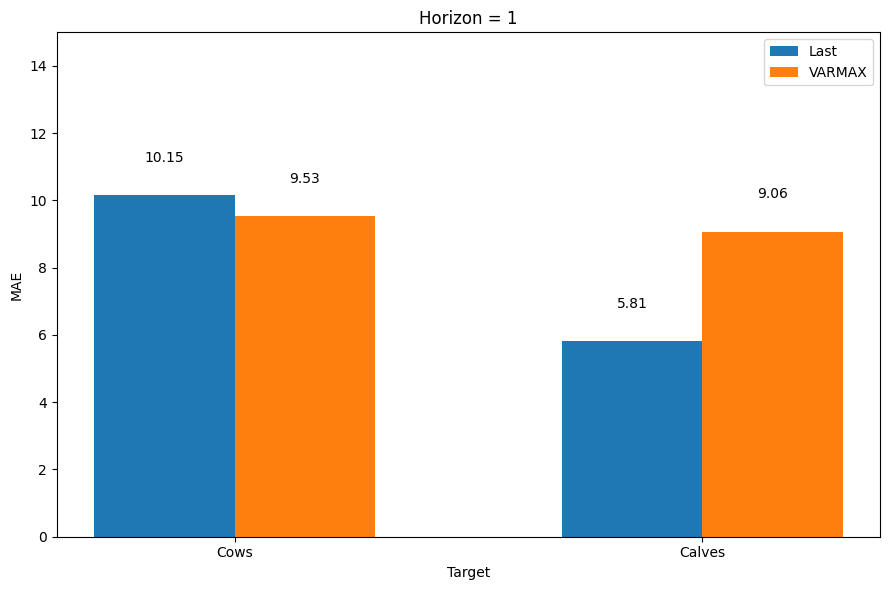

In [52]:
fig, ax = plt.subplots()

width = 0.3
labels = ['Cows', 'Calves']
x = np.arange(len(labels))

y_last = [mae_cow_last, mae_calves_last]
y_VARMAX = [mae_cow_VARMAX, mae_calves_VARMAX]

ax.bar(x - width/2, y_last, width, label='Last')
ax.bar(x + width/2, y_VARMAX, width, label='VARMAX')

ax.set_ylim(0, 15)
ax.set_ylabel('MAE')
ax.set_xlabel('Target')
ax.set_title(f'Horizon = 1')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='best')

for i, v in enumerate(y_last):
    ax.text(x=i - width/2, y=v+1, s=str(round(v, 2)), ha='center')
for i, v in enumerate(y_VARMAX):
    ax.text(x=i + width/2, y=v+1, s=str(round(v, 2)), ha='center')
    
plt.tight_layout()